#第5章 画像分類
##第5.4節 Transformer による手法～DETR を実装してみよう

###モジュールのインポートとGoogleドライブのマウント

In [ ]:
from tqdm import tqdm
from collections import deque
from typing import Callable, Sequence, List, Tuple, Union
import json
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import math
from scipy.optimize import linear_sum_assignment

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.utils import draw_bounding_boxes

# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/5_object_detection/5_4_detr')

import util
import dataset
import transform as T
from model import ResNet18

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###位置エンコーディングを生成するクラス

In [ ]:
class PositionalEncoding:
    '''
    位置エンコーディング生成クラス
    eps        : 0で割るのを防ぐための小さい定数
    temperature: 温度定数
    '''
    def __init__(self, eps: float=1e-6, temperature: int=10000):
        self.eps = eps
        self.temperature = temperature

    '''
    位置エンコーディングを生成する関数
    x   : 特徴マップ, [バッチサイズ, チャネル数, 高さ, 幅]
    mask: 画像領域を表すマスク, [バッチサイズ, 高さ, 幅]
    '''
    @torch.no_grad()
    def generate(self, x: torch.Tensor, mask: torch.Tensor):
        # 位置エンコーディングのチャネル数は入力の半分として
        # x方向のエンコーディングとy方向のエンコーディングを用意し、
        # それらを連結することで入力のチャネル数に合わせる
        num_pos_channels = x.shape[1] // 2

        # 温度定数の指数を計算するため、2の倍数を用意
        dim_t = torch.arange(0, num_pos_channels, 2,
                             dtype=x.dtype, device=x.device)
        # sinとcosを計算するために値を複製
        # [0, 2, ...] -> [0, 0, 2, 2, ...]
        dim_t = dim_t.repeat_interleave(2)
        # sinとcosへの入力のの分母となるT^{2i / d}を計算
        dim_t /= num_pos_channels
        dim_t = self.temperature ** dim_t

        # マスクされていない領域の座標を計算
        inverted_mask = ~mask
        y_encoding = inverted_mask.cumsum(1, dtype=torch.float32)
        x_encoding = inverted_mask.cumsum(2, dtype=torch.float32)

        # 座標を0-1に正規化して2πをかける
        y_encoding = 2 * math.pi * y_encoding / \
            (y_encoding.max(dim=1, keepdim=True)[0] + self.eps)
        x_encoding = 2 * math.pi * x_encoding / \
            (x_encoding.max(dim=2, keepdim=True)[0] + self.eps)

        # 座標を保持するテンソルにチャネル軸を追加して、
        # チャネル軸方向にdim_tで割る
        # 偶数チャネルはsin、奇数チャネルはcosの位置エンコーディング
        y_encoding = y_encoding.unsqueeze(1) / \
            dim_t.view(num_pos_channels, 1, 1)
        y_encoding[:, ::2] = y_encoding[:, ::2].sin()
        y_encoding[:, 1::2] = y_encoding[:, 1::2].cos()
        x_encoding = x_encoding.unsqueeze(1) / \
            dim_t.view(num_pos_channels, 1, 1)
        x_encoding[:, ::2] = x_encoding[:, ::2].sin()
        x_encoding[:, 1::2] = x_encoding[:, 1::2].cos()

        encoding = torch.cat((y_encoding, x_encoding), dim=1)

        return encoding

###Transformerエンコーダ層

In [ ]:
class TransformerEncoderLayer(nn.Module):
    '''
    Transformerエンコーダ層
    dim_hidden     : 特徴量次元
    num_heads      : マルチヘッドアテンションのヘッド数
    dim_feedforward: FNNの中間特徴量次元
    dropout        : ドロップアウト率
    '''
    def __init__(self, dim_hidden: int=256, num_heads: int=8,
                 dim_feedforward: int=2048, dropout: float=0.1):
        super().__init__()

        # 自己アテンションブロックの構成要素
        self.self_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(dim_hidden)

        # FNNブロックの構成要素
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim_hidden)

    '''
    順伝播関数
    x           : 特徴マップの特徴量,
                  [特徴量数, バッチサイズ, 特徴量次元]
    pos_encoding: 位置エンコーディング,
                  [特徴量数, バッチサイズ, 特徴量次元]
    mask        : 画像領域かどうかを表すマスク,
                  [バッチサイズ, 特徴量数]
    '''
    def forward(self, x: torch.Tensor, pos_encoding: torch.Tensor,
                mask: torch.Tensor):
        # クエリとキーには位置エンコーディングを加算することで
        # アテンションの計算に位置の情報が使われるようにする
        q = k = x + pos_encoding

        # self_attenionにはクエリ、キー、バリューの順番に入力
        # key_padding_maskにmaskを渡すことでマスクが真の値を持つ領域の
        # キーは使われなくなり、特徴収集の対象から外れる
        # MutltiheadAttentionクラスは特徴収集結果とアテンションの値の
        # 2つの結果を返すが、特徴収集結果のみを使うので[0]とする
        x2 = self.self_attention(q, k, x, key_padding_mask=mask)[0]
        x = x + self.dropout1(x2)
        x = self.norm1(x)

        x2 = self.fnn(x)
        x = x + self.dropout2(x2)
        x = self.norm2(x)

        return x

###Transformerデコーダ層

In [ ]:
class TransformerDecoderLayer(nn.Module):
    '''
    Transformerデコーダ層
    dim_hidden     : 特徴量次元
    num_heads      : マルチヘッドアテンションのヘッド数
    dim_feedforward: FNNの中間特徴量次元
    dropout        : ドロップアウト率
    '''
    def __init__(self, dim_hidden: int=256, num_heads: int=8,
                 dim_feedforward: float=2048, dropout: float=0.1):
        super().__init__()

        # 物体特徴量の自己アテンションブロックの構成要素
        self.self_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(dim_hidden)

        # 物体特徴量と特徴マップの特徴量の
        # 交差アテンションブロックの構成要素
        self.cross_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout=dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim_hidden)

        # FNNブロックの構成要素
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(dim_hidden)

    '''
    順伝播関数
    h           : 物体特徴量, [クエリ数, バッチサイズ, 特徴量次元]
    query_embed : 物体クエリ埋め込み,
                  [クエリ数, バッチサイズ, 特徴量次元]
    x           : 特徴マップの特徴量,
                  [特徴量数, バッチサイズ, 特徴量次元]
    pos_encoding: 位置エンコーディング,
                  [特徴量数, バッチサイズ, 特徴量次元]
    mask        : 画像領域かどうかを表すマスク,
                  [バッチサイズ, 特徴量数]
    '''
    def forward(self, h: torch.Tensor, query_embed: torch.Tensor,
                x: torch.Tensor, pos_encoding: torch.Tensor,
                mask: torch.Tensor):
        # 物体クエリ埋め込みの自己アテンション
        q = k = h + query_embed
        h2 = self.self_attention(q, k, h)[0]
        h = h + self.dropout1(h2)
        h = self.norm1(h)

        # 物体クエリ埋め込みと特徴マップの交差アテンション
        h2 = self.cross_attention(h + query_embed, x + pos_encoding,
                                  x, key_padding_mask=mask)[0]
        h = h + self.dropout2(h2)
        h = self.norm2(h)

        h2 = self.fnn(h)
        h = h + self.dropout3(h2)
        h = self.norm3(h)

        return h

###Transformer

In [ ]:
class Transformer(nn.Module):
    '''
    エンコーダ層とデコーダ層をまとめるTransformer
    dim_hidden        : 特徴量次元
    num_heads         : マルチヘッドアテンションのヘッド数
    num_encoder_layers: エンコーダ層の数
    num_decoder_layers: デコーダ層の数
    dim_feedforward   : FNNの特徴量次元
    dropout           : ドロップアウト率
    '''
    def __init__(self, dim_hidden: int=256, num_heads: int=8,
                 num_encoder_layers: int=3, num_decoder_layers: int=3,
                 dim_feedforward: int=2048, dropout: float=0.1):
        super().__init__()

        # 引数で指定された数だけエンコーダ層とデコーダ層を用意
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(
                dim_hidden, num_heads, dim_feedforward, dropout)
            for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(
                dim_hidden, num_heads, dim_feedforward, dropout)
            for _ in range(num_decoder_layers)
        ])

        self._reset_parameters()

    '''
    パラメータの初期化関数
    '''
    def _reset_parameters(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    '''
    順伝播関数
    x           : 特徴マップ, [バッチサイズ, チャネル数, 高さ, 幅]
    pos_encoding: 位置エンコーディング,
                  [バッチサイズ, チャネル数, 高さ, 幅]
    mask        : マスク, [バッチサイズ, 高さ, 幅]
    query_embed : 物体クエリ埋め込み, [クエリ数, 特徴量次元]
    '''
    def forward(self, x: torch.Tensor, pos_encoding: torch.Tensor,
                mask: torch.Tensor, query_embed: torch.Tensor):
        bs = x.shape[0]

        ''' 入力をTransformerに入力するために整形 '''
        
        # 特徴マップ:
        # [バッチサイス、チャネル数、高さ、幅]
        # -> [高さ * 幅、バッチサイズ、チャネル数]
        x = x.flatten(2).permute(2, 0, 1)
        
        # 位置エンコーディング:
        # [バッチサイス、チャネル数、高さ、幅]
        # -> [高さ*幅、バッチサイズ、チャネル数]
        pos_encoding = pos_encoding.flatten(2).permute(2, 0, 1)
        
        # マスク:
        # [バッチサイス、高さ、幅] -> [バッチサイズ、高さ*幅]
        mask = mask.flatten(1)
        
        # 物体クエリ埋め込み:
        #[クエリ数、チャネル数]
        # -> [クエリ数、バッチサイズ、チャネル数]
        query_embed = query_embed.unsqueeze(1).expand(-1, bs, -1)

        ''''''''''''''''''''''''''''''''''''''''''''

        # エンコーダ層を直列に適用
        for layer in self.encoder_layers:
            x = layer(x, pos_encoding, mask)

        # デコーダ層を直列に適用
        # 途中のデコーダ層の出力も保持
        hs = []
        h = torch.zeros_like(query_embed)
        for layer in self.decoder_layers:
            h = layer(h, query_embed, x, pos_encoding, mask)
            hs.append(h)

        # 第0軸を追加して各デコーダ層の出力を第0軸で連結
        hs = torch.stack(hs)
        # [デコーダ層数、バッチサイズ、クエリ数、チャネル数]にする
        hs = hs.permute(0, 2, 1, 3)

        return hs

###DETR

In [ ]:
class DETR(nn.Module):
    '''
    DETRモデル(ResNet18バックボーン)
    num_queries       : 物体クエリ埋め込みの数
    dim_hidden        : Transformerで処理する際の特徴量元数
    num_heads         : マルチヘッドアッテンションのヘッド数
    num_encoder_layers: Transformerエンコーダの層数
    num_decoder_layers: Transformerデコーダの層数
    dim_feedforward   : TransformerのFNNの中間特徴量次元
    dropout           : Transformer内でのドロップアウト率
    num_classes       : 物体クラス数
    '''
    def __init__(self, num_queries: int, dim_hidden: int,
                 num_heads: int, num_encoder_layers: int,
                 num_decoder_layers: int, dim_feedforward: int,
                 dropout: float, num_classes: int):
        super().__init__()

        self.backbone = ResNet18()

        # バックボーンネットワークの特徴マップのチャネル数を
        # 減らすための畳み込み層
        self.proj = nn.Conv2d(512, dim_hidden, kernel_size=1)

        self.transformer = Transformer(
            dim_hidden, num_heads, num_encoder_layers,
            num_decoder_layers, dim_feedforward, dropout)

        # 分類ヘッド
        # 背景クラスのために実際の物体クラス数に1を追加
        self.class_head = nn.Linear(dim_hidden, num_classes + 1)

        # 矩形ヘッド
        self.box_head = nn.Sequential(
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, 4),
        )

        self.positional_encoding = PositionalEncoding()

        # 物体クラス埋め込み
        self.query_embed = nn.Embedding(num_queries, dim_hidden)

    '''
    順伝播関数
    x   : 入力画像, [バッチサイズ, チャネル数, 高さ, 幅]
    mask: 画像領域かどうかを表すマスク, [バッチサイズ, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        # バックボーンネットワークから第5レイヤーの特徴マップを取得
        x = self.backbone(x)[-1]
        # Transformer処理用に特徴マップのチャネル数を削減
        x = self.proj(x)

        # 入力画像と同じ大きさを持つmaskを特徴マップの大きさにリサイズ
        # interpolate関数はbool型には対応していないため、一旦xと
        # 同じ型に変換
        mask = mask.to(x.dtype)
        mask = F.interpolate(
            mask.unsqueeze(1), size=x.shape[2:])[:, 0]
        mask = mask.to(torch.bool)

        pos_encoding = self.positional_encoding.generate(x, mask)

        hs = self.transformer(
            x, pos_encoding, mask, self.query_embed.weight)

        preds_class = self.class_head(hs)
        preds_box = self.box_head(hs).sigmoid()

        return preds_class, preds_box

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.backbone.conv1.weight.device

###後処理を行う関数

In [ ]:
'''
preds_class: 検出矩形のクラス, [バッチサイズ, クエリ数, 物体クラス数]
preds_box  : 検出矩形の位置と大きさ,
             [バッチサイズ, クエリ数, 4 (x, y, w, h)]
targets    : ラベル
include_bg : 分類結果に背景を含めるかどうかを表す真偽値
'''
@torch.no_grad()
def post_process(preds_class: torch.Tensor, preds_box: torch.Tensor,
                 targets: dict, include_bg: bool=False):
    probs = preds_class.softmax(dim=2)

    # 分類結果に背景クラスを含めるかどうか
    # 含めない場合は背景クラス以外で最大の確率を持つクラスに分類
    if include_bg:
        scores, labels = probs.max(dim=2)
    else:
        scores, labels = probs[:, :, :-1].max(dim=2)

    # 検出矩形の整形
    boxes = util.convert_to_xyxy(preds_box)
    # 矩形をミニバッチのサンプル毎の画像の大きさに合わせる
    img_sizes = torch.stack([target['orig_size']
                             for target in targets])
    boxes[:, :, ::2] *= img_sizes[:, 0].view(-1, 1, 1)
    boxes[:, :, 1::2] *= img_sizes[:, 1].view(-1, 1, 1)

    return scores, labels, boxes

###GIoUを計算する関数

In [ ]:
'''
boxes1: 矩形集合, [矩形数, 4 (xmin, ymin, xmax, ymax)]
boxes2: 矩形集合, [矩形数, 4 (xmin, ymin, xmax, ymax)]
'''
def calc_giou(boxes1: torch.Tensor, boxes2: torch.Tensor):
    ious, union = util.calc_iou(boxes1, boxes2)

    # 二つの矩形を包含する最小の矩形の面積を計算
    left_top = torch.minimum(
        boxes1[:, :2].unsqueeze(1), boxes2[:, :2])
    right_bottom = torch.maximum(
        boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:])
    width_height = (right_bottom - left_top).clamp(min=0)
    areas = width_height.prod(dim=2)

    return ious - (areas - union) / areas

###検出矩形と正解矩形の割り当てを行うハンガリアンアルゴリズム関数

In [ ]:
'''
preds_class         : 検出矩形のクラス,
                      [バッチサイズ, クエリ数, 物体クラス数]
preds_box           : 検出矩形の位置と大きさ,
                      [バッチサイズ, クエリ数, 4 (x, y, w, h)]
targets             : ラベル
loss_weight_class   : コストを計算する際の分類コストの重み
loss_weight_box_l1  : コストを計算する際の矩形のL1コストの重み
loss_weight_box_giou: コストを計算する際の矩形のGIoUコストの重み
'''
@torch.no_grad()
def _hungarian_match(preds_class: torch.Tensor,
                     preds_box: torch.Tensor, targets: dict,
                     loss_weight_class: float=1.0,
                     loss_weight_box_l1: float=5.0,
                     loss_weight_box_giou: float=2.0):
    bs, num_queries = preds_class.shape[:2]

    # コスト計算を全てのサンプル一括で計算するため、
    # 全てのサンプルの予測結果を一旦第0軸に並べる
    preds_class = preds_class.flatten(0, 1).softmax(dim=1)
    preds_box = preds_box.flatten(0, 1)

    # 予測結果と同様に全てのサンプルの正解ラベルを一旦第0軸に並べる
    targets_class = torch.cat([target['classes']
                               for target in targets])
    # 正解矩形の値を正規化された画像上の座標に変換
    targets_box = torch.cat(
        [target['boxes'] / target['size'].repeat(2)
         for target in targets])

    # 分類のコストは正解クラスの予測確率にマイナスをかけたもの
    # 正解クラスの予測確率が高ければ高いほどコストが小さくなる
    cost_class = -preds_class[:, targets_class]

    # 矩形回帰の1つめのコストとなる予測結果と正解のL1誤差の計算
    cost_box_l1 = torch.cdist(
        preds_box, util.convert_to_xywh(targets_box), p=1)

    # 矩形回帰の2つめのコストとなる予測結果と正解のGIoU損失の計算
    cost_box_giou = -calc_giou(
        util.convert_to_xyxy(preds_box), targets_box)

    cost = loss_weight_class * cost_class + \
        loss_weight_box_l1 * cost_box_l1 + \
        loss_weight_box_giou * cost_box_giou

    # 一括で計算していたコストをサンプル毎に分解するため軸を変更
    # 検出矩形の軸を分解して、
    # [バッチサイズ、クエリ数、全サンプルの正解数]という軸構成になる
    cost = cost.view(bs, num_queries, -1)

    # SciPyのlinear_sum_assignment関数を適用するためCPUへ転送
    cost = cost.to('cpu')

    # 各サンプルの正解矩形数を計算
    sizes = [len(target['classes']) for target in targets]

    indices = []
    # 第2軸を各サンプルの正解矩形数で分解し、バッチ軸でサンプルを
    # 指定することで、各サンプルのコスト行列を取得
    for batch_id, c in enumerate(cost.split(sizes, dim=2)):
        c_batch = c[batch_id]
        # ハンガリアンアルゴリズムにより予測結果と正解のマッチング
        # クエリのインデックスと正解のインデックスを得る
        pred_indices, target_indices = linear_sum_assignment(c_batch)
        indices.append((
            torch.tensor(pred_indices, dtype=torch.int64),
            torch.tensor(target_indices, dtype=torch.int64)))

    return indices

###並べ替えのためのインデックスを生成する関数

In [ ]:
'''
indices: ハンガリアンアルゴリズムにより得られたインデックス
'''
def _get_pred_permutation_index(
    indices: List[Tuple[torch.Tensor]]):
    # マッチした予測結果のバッチインデックスを1つの軸に並べる
    batch_indices = torch.cat(
        [torch.full_like(pred_indices, i)
         for i, (pred_indices, _) in enumerate(indices)])
    # マッチした予測結果のクエリインデックスを1つの軸に並べる
    pred_indices = torch.cat([pred_indices
                              for (pred_indices, _) in indices])

    return batch_indices, pred_indices

###分類損失を計算する関数

In [ ]:
'''
preds            : 検出矩形のクラス,
                   [バッチサイズ, クエリ数, 物体クラス数]
targets          : ラベル
indices          : ハンガリアンアルゴリズムにより得られたインデックス
background_weight: 背景クラスの交差エントロピー誤差の重み
'''
def _class_loss_func(preds: torch.Tensor, targets: dict,
                     indices: List[Tuple[torch.Tensor]],
                     background_weight: float):
    pred_indices = _get_pred_permutation_index(indices)

    # 物体クラス軸の最後の次元が背景クラス
    background_id = preds.shape[2] - 1

    # 正解ラベルとなるテンソルの作成
    # [バッチサイズ、クエリ数]のテンソルを作成し、背景IDを設定
    targets_class = preds.new_full(
        preds.shape[:2], background_id, dtype=torch.int64)
    # マッチした予測結果の部分に正解ラベルとなる物体クラスIDを代入
    targets_class[pred_indices] = torch.cat(
        [target['classes'][target_indices]
         for target, (_, target_indices) in zip(targets, indices)])

    # 背景クラスの正解数が多く、正解数に不均衡が生じるため、
    # 背景クラスの重みを下げる
    weights = preds.new_ones(preds.shape[2])
    weights[background_id] = background_weight

    loss = F.cross_entropy(preds.transpose(1, 2),
                           targets_class, weights)

    return loss

###矩形の回帰損失を計算する関数

In [ ]:
'''
preds  : 検出矩形の位置と大きさ,
         [バッチサイズ, クエリ数, 4 (x, y, w, h)]
targets: ラベル
indices: ハンガリアンアルゴリズムにより得られたインデックス
'''
def _box_loss_func(preds: torch.Tensor, targets: dict,
                   indices: List[Tuple[torch.Tensor]]):
    pred_indices = _get_pred_permutation_index(indices)

    # マッチした予測結果を抽出
    preds = preds[pred_indices]

    # マッチした正解を抽出
    targets_box = torch.cat([
        target['boxes'][target_indices] / target['size'].repeat(2)
        for target, (_, target_indices) in zip(targets, indices)])

    # 0除算を防ぐために、最小値が1になるように計算
    num_boxes = max(1, targets_box.shape[0])

    # マッチした予測結果と正解でL1誤差を計算
    loss_l1 = F.l1_loss(preds, util.convert_to_xywh(targets_box),
                        reduction='sum') / num_boxes

    # マッチした予測結果と正解でGIoU損失を計算
    gious = calc_giou(util.convert_to_xyxy(preds), targets_box)
    loss_giou = (1 - gious.diag()).sum() / num_boxes

    return loss_l1, loss_giou

###損失を計算する関数

In [ ]:
'''
preds_class         : 検出矩形のクラス,
                      [バッチサイズ, クエリ数, 物体クラス数]
preds_box           : 検出矩形の位置と大きさ,
                      [バッチサイズ, クエリ数, 4 (x, y, w, h)]
targets             : ラベル
loss_weight_class   : コストを計算する際の分類コストの重み
loss_weight_box_l1  : コストを計算する際の矩形のL1コストの重み
loss_weight_box_giou: コストを計算する際の矩形のGIoUコストの重み
'''
def loss_func(preds_class: torch.Tensor, preds_box: torch.Tensor,
              targets: dict, loss_weight_class: float=1.0,
              loss_weight_box_l1: float=5.0,
              loss_weight_box_giou: float=2.0,
              background_weight: float=0.1):
    indices = _hungarian_match(preds_class, preds_box, targets,
                               loss_weight_class, loss_weight_box_l1,
                               loss_weight_box_giou)

    loss_class = loss_weight_class * _class_loss_func(
        preds_class, targets, indices, background_weight)
    loss_box_l1, loss_box_giou = _box_loss_func(
        preds_box, targets, indices)
    loss_box_l1 = loss_weight_box_l1 * loss_box_l1
    loss_box_giou = loss_weight_box_giou * loss_box_giou

    return loss_class, loss_box_l1, loss_box_giou

###学習・評価におけるハイパーパラメータやオプションの設定

In [ ]:
class ConfigTrainEval:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 画像があるディレクトリ
        self.img_directory = 'val2014'
        # アノテーションファイルのパス
        self.anno_file = 'drive/MyDrive/data/coco2014/instances_val2014_small.json'
        # パラメータを保存するパス
        self.save_file = 'detr.pth'
        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.2
        # 学習エポック数
        self.num_epochs = 100
        # 学習率を減衰させるエポック
        self.lr_drop = 90
        # 検証を行うエポック間隔
        self.val_interval = 5
        # 学習率
        self.lr = 1e-4
        # バックボーンネットワークの学習率
        self.lr_backbone = 1e-5
        # 荷重減衰
        self.weight_decay = 1e-4
        # 勾配のクリップ上限
        self.clip = 0.1
        # 物体クエリ埋め込みのクエリベクトル数
        self.num_queries = 100
        # Transformer内の特徴量次元
        self.dim_hidden = 256
        # マルチヘッドアテンションのヘッド数
        self.num_heads = 8
        # Transformerエンコーダの層数
        self.num_encoder_layers = 6
        # Transformerデコーダの層数
        self.num_decoder_layers = 6
        # Transformer内のFNNの中間特徴量次元
        self.dim_feedforward = 2048
        # Transformer内のドロップアウト率
        self.dropout = 0.1
        # 分類損失の重み
        self.loss_weight_class = 1
        # 矩形回帰のL1誤差の重み
        self.loss_weight_box_l1 = 5
        # 矩形回帰のGIoU損失の重み
        self.loss_weight_box_giou = 2
        # 背景クラスの重み
        self.background_weight = 0.1
        # 移動平均で計算する損失と正確度の値の数
        self.moving_avg = 100
        # バッチサイズ
        self.batch_size = 8
        # データローダーに使うCPUプロセスの数
        self.num_workers = 2
        # 学習に使うデバイス
        self.device = 'cuda'

###学習・評価を行う関数

In [ ]:
def train_eval():
    config = ConfigTrainEval()
    
    # データ拡張・整形クラスの設定
    min_sizes = (480, 512, 544, 576, 608)
    train_transforms = T.Compose((
        T.RandomHorizontalFlip(),
        T.RandomSelect(
            T.RandomResize(min_sizes, max_size=1024),
            T.Compose((
                T.RandomSizeCrop(scale=(0.8, 1.0),
                                 ratio=(0.75, 1.333)),
                T.RandomResize(min_sizes, max_size=1024),
            ))
        ),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
    ))
    test_transforms = T.Compose((
        # テストは短辺最大で実行
        T.RandomResize((min_sizes[-1],), max_size=1333),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
    ))

    # データセットの用意
    train_dataset = dataset.CocoDetection(
        img_directory=config.img_directory,
        anno_file=config.anno_file,
        transform=train_transforms)
    val_dataset = dataset.CocoDetection(
        img_directory=config.img_directory,
        anno_file=config.anno_file,
        transform=test_transforms)

    # Subset samplerの生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数: {len(train_set)}')
    print(f'検証セットのサンプル数: {len(val_set)}')

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler,
        collate_fn=collate_func)
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set,
        collate_fn=collate_func)

    # DETR(ResNet18 backbone)モデルの生成
    model = DETR(config.num_queries, config.dim_hidden,
                 config.num_heads, config.num_encoder_layers,
                 config.num_decoder_layers, config.dim_feedforward,
                 config.dropout, len(train_dataset.classes))
    model.backbone.load_state_dict(torch.hub.load_state_dict_from_url(
        'https://download.pytorch.org/models/resnet18-5c106cde.pth'),
                                   strict=False)

    # モデルを指定デバイスに転送
    model.to(config.device)

    # Optimizerの生成, バックボーンとそうでないモジュールとの
    # パラメータで異なる学習率を適用
    params_backbone = []
    params_others = []
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            if 'backbone' in name:
                params_backbone.append(parameter)
            else:
                params_others.append(parameter)
    param_groups = [
        {'params': params_backbone, 'lr': config.lr_backbone},
        {'params': params_others, 'lr': config.lr}]
    optimizer = optim.AdamW(param_groups,
                            weight_decay=config.weight_decay)

    # 指定したエポックで学習率を1/10に減衰するスケジューラを生成
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[config.lr_drop], gamma=0.1)

    # 目的関数に予めハイパーパラメータをセット
    loss_func_lambda = lambda preds_class, preds_box, targets: \
        loss_func(preds_class, preds_box, targets,
                  config.loss_weight_class, config.loss_weight_box_l1,
                  config.loss_weight_box_giou,
                  config.background_weight)

    for epoch in range(config.num_epochs):
        model.train()

        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses_class = deque()
            losses_box_l1 = deque()
            losses_box_giou = deque()
            losses_aux = deque()
            losses = deque()
            for imgs, masks, targets in pbar:
                imgs = imgs.to(model.get_device())
                masks = masks.to(model.get_device())
                targets = [{
                    k: v.to(model.get_device())
                    for k, v in target.items()} for target in targets]

                optimizer.zero_grad()

                preds_class, preds_box = model(imgs, masks)

                # 補助損失を計算
                loss_aux = 0
                for layer_index in range(
                    config.num_decoder_layers - 1):
                    loss_aux += sum(loss_func_lambda(
                        preds_class[layer_index],
                        preds_box[layer_index], targets))

                loss_class, loss_box_l1, loss_box_giou = \
                    loss_func_lambda(preds_class[-1], preds_box[-1],
                                     targets)
                loss = loss_aux + loss_class + \
                    loss_box_l1 + loss_box_giou

                loss.backward()

                # 勾配全体のL2ノルムが上限を越えるとき上限値でクリップ
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), config.clip)

                optimizer.step()

                losses_class.append(loss_class.item())
                losses_box_l1.append(loss_box_l1.item())
                losses_box_giou.append(loss_box_giou.item())
                losses_aux.append(loss_aux.item())
                losses.append(loss.item())
                if len(losses) > config.moving_avg:
                    losses_class.popleft()
                    losses_box_l1.popleft()
                    losses_box_giou.popleft()
                    losses_aux.popleft()
                    losses.popleft()
                pbar.set_postfix(
                    {'loss': torch.Tensor(losses).mean().item(),
                     'loss_class': torch.Tensor(
                         losses_class).mean().item(),
                     'loss_box_l1': torch.Tensor(
                         losses_box_l1).mean().item(),
                     'loss_box_giou': torch.Tensor(
                         losses_box_giou).mean().item(),
                     'loss_aux': torch.Tensor(
                         losses_aux).mean().item()})

        # スケジューラでエポック数をカウント
        scheduler.step()

        # パラメータを保存
        torch.save(model.state_dict(), config.save_file)

        # 検証
        if (epoch + 1) % config.val_interval == 0:
            evaluate(val_loader, model, loss_func_lambda)


###サンプルからミニバッチを生成するcollate関数

In [ ]:
'''
batch: CocoDetectionからサンプルした複数の画像とラベルをまとめたもの
'''
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, dict]]]):
    # ミニバッチの中の画像で最大の高さと幅を取得
    max_height = 0
    max_width = 0
    for img, _ in batch:
        height, width = img.shape[1:]
        max_height = max(max_height, height)
        max_width = max(max_width, width)

    imgs = batch[0][0].new_zeros(
        (len(batch), 3, max_height, max_width))
    # 真偽値を保持するマスクのテンソルは真の値で初期化
    masks = batch[0][0].new_ones(
        (len(batch), max_height, max_width), dtype=torch.bool)
    targets = []
    for i, (img, target) in enumerate(batch):
        height, width = img.shape[1:]
        imgs[i, :, :height, :width] = img
        # 画像領域には偽の値を設定
        masks[i, :height, :width] = False

        targets.append(target)

    return imgs, masks, targets

###評価関数

In [ ]:
'''
data_loader   : 評価に使うデータを読み込むデータローダ
model         : 評価対象のモデル
loss_func     : 目的関数
conf_threshold: 信頼度の閾値
nms_threshold : NMSのIoU閾値
'''
def evaluate(data_loader, model, loss_func):
    model.eval()

    losses_class = []
    losses_box_l1 = []
    losses_box_giou = []
    losses_aux = []
    losses = []
    preds = []
    img_ids = []
    for imgs, masks, targets in tqdm(
            data_loader, desc='[Validation]'):
        with  torch.no_grad():
            imgs = imgs.to(model.get_device())
            masks = masks.to(model.get_device())
            targets = [{k: v.to(model.get_device())
                        for k, v in target.items()}
                       for target in targets]

            preds_class, preds_box = model(imgs, masks)

            num_decoder_layers = preds_class.shape[0]

            loss_aux = 0
            for layer_index in range(num_decoder_layers - 1):
                loss_aux += sum(loss_func(preds_class[layer_index],
                                          preds_box[layer_index],
                                          targets))

            loss_class, loss_box_l1, loss_box_giou = loss_func(
                preds_class[-1], preds_box[-1], targets)
            loss = loss_class + loss_box_l1 + loss_box_giou + loss_aux

            losses_class.append(loss_class)
            losses_box_l1.append(loss_box_l1)
            losses_box_giou.append(loss_box_giou)
            losses_aux.append(loss_aux)
            losses.append(loss)

            # 後処理により最終的な検出矩形を取得
            scores, labels, boxes = post_process(
                preds_class[-1], preds_box[-1], targets)

            for img_scores, img_labels, img_boxes, img_targets in zip(
                    scores, labels, boxes, targets):
                img_ids.append(img_targets['image_id'].item())

                # 評価のためにCOCOの元々の矩形表現である
                # xmin, ymin, width, heightい変換
                img_boxes[:, 2:] -= img_boxes[:, :2]

                for score, label, box in zip(
                        img_scores, img_labels, img_boxes):
                    # COCO評価用のデータの保存
                    preds.append({
                        'image_id': img_targets['image_id'].item(),
                        'category_id': \
                        data_loader.dataset.to_coco_label(
                            label.item()),
                        'score': score.item(),
                        'bbox': box.to('cpu').numpy().tolist()
                    })

    loss_class = torch.stack(losses_class).mean().item()
    loss_box_l1 = torch.stack(losses_box_l1).mean().item()
    loss_box_giou = torch.stack(losses_box_giou).mean().item()
    loss_aux = torch.stack(losses_aux).mean().item()
    loss = torch.stack(losses).mean().item()
    print(f'Validation loss = {loss:.3f}, '
          f'class loss = {loss_class:.3f}, '
          f'box l1 loss = {loss_box_l1:.3f}, '
          f'box giou loss = {loss_box_giou:.3f}, '
          f'aux loss = {loss_aux:.3f}')

    if len(preds) == 0:
        print('Nothing detected, skip evaluation.')

        return

    # pycocotoolsを使って評価するには検出結果をjsonファイルに出力する
    # 必要があるため、jsonファイルに一時保存
    with open('tmp.json', 'w') as f:
        json.dump(preds, f)

    # 一時保存した検出結果をpycocotoolsを使って読み込み
    coco_results = data_loader.dataset.coco.loadRes('tmp.json')

    # pycocotoolsを使って評価
    coco_eval = COCOeval(
        data_loader.dataset.coco, coco_results, 'bbox')
    coco_eval.params.imgIds = img_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


###学習・評価データの解凍

In [ ]:
!unzip drive/MyDrive/python_image_recognition/data/coco2014/val2014.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: v

###学習・評価の実行

In [ ]:
train_eval()

loading annotations into memory...
Done (t=1.89s)
creating index...
index created!
loading annotations into memory...
Done (t=1.31s)
creating index...
index created!
学習セットのサンプル数: 8000
検証セットのサンプル数: 2000


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[エポック 1]: 100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s, loss=21.2, loss_class=0.665, loss_box_l1=1.25, loss_box_giou=1.64, loss_aux=17.6]


###デモおけるハイパーパラメータやオプションの設定

In [ ]:
class ConfigDemo:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 画像があるディレクトリ
        self.img_directory = 'drive/MyDrive/python_image_recognition/data/object_detection'
        # 学習済みパラメータのパス
        self.load_file = 'detr.pth'
        # 検出対象の物体クラス
        self.classes = ['person', 'car']
        # 物体クエリ埋め込みのクエリベクトル数
        self.num_queries = 100
        # Transformer内の特徴量次元
        self.dim_hidden = 256
        # マルチヘッドアテンションのヘッド数
        self.num_heads = 8
        # Transformerエンコーダの層数
        self.num_encoder_layers = 6
        # Transformerデコーダの層数
        self.num_decoder_layers = 6
        # Transformer内のFNNの中間特徴量次元
        self.dim_feedforward = 2048
        # Transformer内のドロップアウト率
        self.dropout = 0.1
        # 学習に使うデバイス
        self.device = 'cuda'

###デモを行う関数

In [ ]:
def demo():
    config = ConfigDemo()
    
    transforms = T.Compose((
        T.RandomResize((608,), max_size=1024),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
    ))

    # 学習済みのモデルパラメータを読み込み
    model = DETR(config.num_queries, config.dim_hidden,
                 config.num_heads, config.num_encoder_layers,
                 config.num_decoder_layers, config.dim_feedforward,
                 config.dropout, len(config.classes))
    model.load_state_dict(torch.load(config.load_file))
    model.to(config.device)
    model.eval()

    for img_path in Path(config.img_directory).iterdir():
        img_orig = Image.open(img_path)
        width, height = img_orig.size

        # データ整形を適用するためにダミーのラベルを作成
        target = {
            'classes': torch.zeros((0,), dtype=torch.int64),
            'boxes': torch.zeros((0, 4), dtype=torch.float32),
            'size': torch.tensor((width, height), dtype=torch.int64),
            'orig_size': torch.tensor(
                (width, height), dtype=torch.int64),
        }

        # データ整形
        img, target = transforms(img_orig, target)
        imgs, masks, targets = collate_func([(img, target)])

        with  torch.no_grad():
            imgs = imgs.to(model.get_device())
            masks = masks.to(model.get_device())
            targets = [{k: v.to(model.get_device())
                        for k, v in target.items()}
                       for target in targets]

            preds_class, preds_box = model(imgs, masks)

            scores, labels, boxes = post_process(
                preds_class[-1], preds_box[-1], targets,
                include_bg=True)

            # 背景クラスに分類された矩形を除外
            boxes = boxes[0, labels[0] != len(config.classes)]
            labels = labels[0, labels[0] != len(config.classes)]

            # 描画用の画像を用意
            img = torch.tensor(np.asarray(img_orig))
            img = img.permute(2, 0, 1)

            # クラスIDをクラス名に変換
            labels = [config.classes[label] for label in labels]

            # 矩形を描画
            img = draw_bounding_boxes(
                img, boxes, labels, colors='red',
                font='LiberationSans-Regular.ttf',
                font_size=42, width=4)
            img = img.permute(1, 2, 0)
            img = img.to('cpu').numpy()

            plt.imshow(img)
            plt.show()

###デモの実行

/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


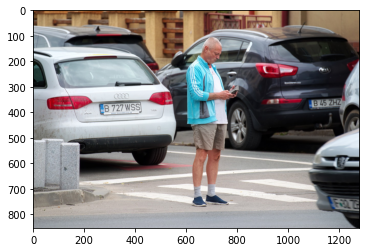

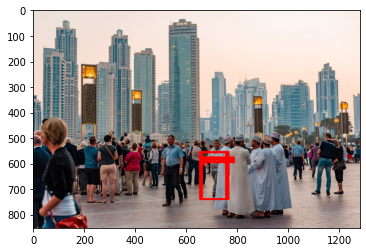

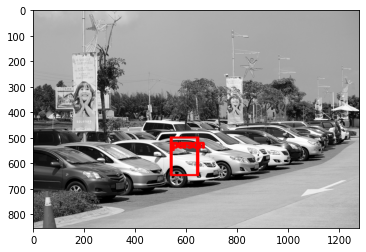

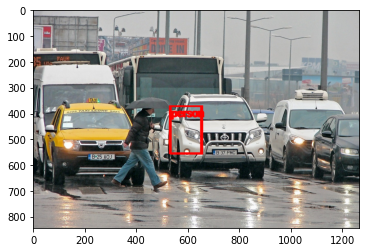

In [ ]:
demo()